# Step-3 Inference & Evaluation(Compute AP)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import time

from matplotlib import patches
from keras.models import model_from_json
from tqdm.notebook import tqdm
from PIL import Image

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load Network Model
def LoadModel(structure_file, weight_file):
    # Network model structure load
    with open(structure_file, 'r') as f:
        model = model_from_json(f.read())
    
    # Trained weight load and copy to model
    model.load_weights(weight_file)
    
    return model


In [3]:
def SelectiveSearch(img):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    
    # ssresults의 bbow 좌표 포맷 x, y, w, h
    # 현재 코드에서 사용되는 bbox 좌표 포맷은 xmin, ymin, xmax, ymax
    # IOU 계산 및  DrawBox 함수 모듈화를 위해 convert
    ssresults[:, 2] = ssresults[:, 0] + ssresults[:, 2]
    ssresults[:, 3] = ssresults[:, 1] + ssresults[:, 3]
    return ssresults

In [4]:
def ParseAnnotations(test_list):
    annotations = dict()
    
    for ele in test_list:
        ann_path = os.path.join(ANN_DIR, '{}.csv'.format(ele.split('.')[0]))
        ann = pd.read_csv(ann_path)
        gt_bboxes = np.array([], dtype=np.int32).reshape(0, 4)

        for row in ann.iterrows():
            line = row[1][0].split(" ")
            x1 = int(line[0])
            y1 = int(line[1])
            x2 = int(line[2])
            y2 = int(line[3])
            gt_bboxes = np.vstack([gt_bboxes, [x1, y1, x2, y2]])
        
        annotations[ele] = gt_bboxes
        
    return annotations       

In [5]:
def FeedForward(model, data, img, out_dim):
    results = np.array([], dtype=np.float32).reshape(0, out_dim)
    for i in data:
        timg = img[int(i[1]) : int(i[3]), int(i[0]) : int(i[2])]
        rimg = cv2.resize(timg, (224, 224), interpolation = cv2.INTER_AREA)
        rimg = np.divide(rimg, 255.)
        inimg = np.expand_dims(rimg, axis=0)
        output = model.predict(inimg)
        results = np.vstack([results, output])
    
    return results

In [6]:
def PredictObject(model, rois, img):
    # Classification Feed Forward
    results = FeedForward(model, rois, img, 2)

    idx = np.where(results[:,1] > 0.75)[0]
    rois = rois[idx]
    results = results[idx, 1]
    predict = np.column_stack([rois, results])
    
    return predict

In [7]:
def RefineBoundingBox(predict_bbox, reg_output):
    refine_bbox = predict_bbox.copy()
    
    if refine_bbox.shape[0] > 0:
        refine_bbox[:, 0] = np.trunc((refine_bbox[:, 2] * reg_output[:, 0]) + refine_bbox[:, 0])
        refine_bbox[:, 1] = np.trunc((refine_bbox[:, 3] * reg_output[:, 1]) + refine_bbox[:, 1])
        refine_bbox[:, 2] = np.trunc(refine_bbox[:, 2] * np.exp(reg_output[:, 2]))
        refine_bbox[:, 3] = np.trunc(refine_bbox[:, 3] * np.exp(reg_output[:, 3]))
    
    return refine_bbox

In [8]:
def BoundingBoxRegression(model, predict_bbox, img):
    # Regression Feed Forward
    results = FeedForward(model, predict_bbox, img, 4)
    
    # Refine Bounding box
    refine_bbox = RefineBoundingBox(predict_bbox, results)
    
    return refine_bbox

In [9]:
# Compute IOU(Measure TP, FP)
def ComputeIOU(gt_bbox, p):
    x1 = np.maximum(gt_bbox[0], p[:, 0])
    y1 = np.maximum(gt_bbox[1], p[:, 1])
    x2 = np.minimum(gt_bbox[2], p[:, 2])
    y2 = np.minimum(gt_bbox[3], p[:, 3])
    
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    propoesed_area = (p[:, 2] - p[:, 0]) * (p[:, 3] - p[:, 1])
    union = gt_area + propoesed_area[:] - intersection[:]
    
    iou = intersection/union
    
    return iou

In [10]:
# Bounding Box Normalization
def NonMaximumSuppression(boxes):
    NMS_TH = 0.5
    pick = []

    # Sorted by Score(Confidence)
    idx = np.argsort(boxes[:, 4])

    while len(idx) > 0:
        last = len(idx) - 1
        i = idx[last]
        pick.append(i)
        iou = ComputeIOU(boxes[i], boxes[idx[:last]])
        idx = np.delete(idx, np.concatenate(([last], np.where(iou > NMS_TH)[0])))

    return boxes[pick]

In [11]:
def DrawBoxes(img, bboxes, title='Empty', color='magenta', linestyle="solid", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))
    
    # BBox Display
    # Box 좌표 구성(xmin, ymin, xmax, ymax)
    for bbox in bboxes:
        p = patches.Rectangle((bbox[0], bbox[1]), (bbox[2]-bbox[0]), (bbox[3]-bbox[1]), linewidth=2, alpha=1.0, linestyle=linestyle, edgecolor=color, facecolor='none')
        ax.add_patch(p)

    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(title)

In [12]:
def PerformanceMeasure_old(gt_bboxes, p_bbox):
    MEASURE_TH = 0.5
    eval_results = np.array([], dtype=np.int32).reshape(0, 6)

    for gt_bbox in gt_bboxes:
        # GT와 Predict 사이의 IOU 계산
        iou = ComputeIOU(gt_bbox, p_bbox)
        
        # 지정한 임계 값 보다 큰 iou index 추출
        measure = np.where(iou > MEASURE_TH)[0]

        if len(measure) == 0:
            continue

        # GT 당 1개의 Predict BBox가 있다면 TP,
        # 여러개의 Predict BBox가 있다면 1개만 TP 나머지는 FP
        if len(measure) == 1:
            tmp_tp = np.insert(p_bbox[measure], 5, 1, axis=1)
            eval_results = np.vstack([eval_results, tmp_tp])
        else:
            sub_bbox = p_bbox[measure]
            # Confident Score 값이 가장 큰 경우
            # tp_idx = np.argmax(sub_bbox[:,-1])
            # IOU 값이 가장 큰 경우
            tp_idx = np.argmax(iou[measure])
            tmp_tp = np.insert(sub_bbox[tp_idx], 5, 1)

            eval_results = np.vstack([eval_results, tmp_tp])
            sub_bbox = np.delete(sub_bbox, tp_idx, axis=0)

            if len(sub_bbox) > 0:
                tmp_fp = np.insert(sub_bbox[:], 5, 0, axis=1)
                eval_results = np.vstack([eval_results, tmp_fp])

        p_bbox = np.delete(p_bbox, measure, axis=0)

    # TP Measure 후 남은 Bounding Box는 모두 FP
    if len(p_bbox) > 0:
        p_bbox = np.insert(p_bbox, 5, 0, axis=1)
        eval_results = np.vstack([eval_results, p_bbox])

    return eval_results

In [13]:
def PerformanceMeasure(gt_bboxes, p_bbox):
    MEASURE_TH = 0.5
    # Default Value 모두 FP(False Positive)
    p_bbox = np.insert(p_bbox[:], 5, 0, axis=1)
    
    for gt_bbox in gt_bboxes:
        iou = ComputeIOU(gt_bbox, p_bbox)
        measure = np.where(iou > MEASURE_TH)[0]
        if len(measure) != 0:
            p_bbox[np.argmax(iou), 5] = 1

    return p_bbox

In [14]:
def ComputePrecRec(results):
    #Compute num_of_object
    results[:,6]
    image_ids = np.unique(results[:,6])
    
    num_of_object = 0
    for i in image_ids:
        num_of_object += annotations[test_list[int(i)]].shape[0]
    
    results = results[np.argsort(-results[:, 4])]
    
    acc_tp = 0
    acc_fp = 0
    prec = np.array([], dtype=np.float32).reshape(0, 1)
    rec = np.array([], dtype=np.float32).reshape(0, 1)

    for i in results[:, 5]:
        if i == 1:
            acc_tp += 1
        elif i == 0:
            acc_fp += 1

        prec = np.vstack([prec, acc_tp / (acc_tp + acc_fp)])
        rec = np.vstack([rec, acc_tp / num_of_object])
    
    return prec, rec

def ComputeAP(results, mode=1):
    # Compute Precision & Recall
    prec, rec = ComputePrecRec(results)
    
    re_rec = np.array([])
    re_prec = np.array([])
    average_precision = 0
    
    if mode == 0:
        re_rec = np.unique(rec)
        re_prec = np.empty_like(re_rec)
        for idx, val in enumerate(re_rec):
            samples = prec[np.where(rec[:, 0] >= val)[0]]
            re_prec[idx] = np.max(samples) if len(samples) != 0 else 0.0

        re_rec = np.insert(re_rec, 0, 0.0)
        average_precision = 0
        for i in range(1, len(re_rec)):
            average_precision += (re_rec[i]-re_rec[i-1]) * re_prec[i-1]
        re_rec = np.delete(re_rec, 0)
    elif mode == 1:
        re_rec = np.arange(0, 1.1, 0.1)
        re_prec = np.empty_like(re_rec)
        for idx, val in enumerate(re_rec):
            samples = prec[np.where(rec[:, 0] >= val)[0]]
            re_prec[idx] = np.max(samples) if len(samples) != 0 else 0.0
        average_precision = np.mean(re_prec)
    
    return average_precision, re_prec, re_rec
    

In [15]:
def Inference(image_id, file_name):
    # Image Load
    img = cv2.imread(os.path.join(IMG_DIR, file_name))

    # Proposal regions using Selective Search
    rois = SelectiveSearch(img)

    # Predict object
    predict_bbox = PredictObject(cls_model, rois, img)
    #print('Predict BBox Shape ::', predict_bbox.shape)

    # Apply Bounding Box Regression
    refine_bbox = BoundingBoxRegression(reg_model, predict_bbox, img)
    #print('Refine BBox Shape ::', refine_bbox.shape)

    # Apply Non Maximum Suppression
    nms_bbox = NonMaximumSuppression(refine_bbox)
    #print('Before regions ::', refine_bbox.shape)
    #print('NMS regions ::', nms_bbox.shape)

    # Performance Measure
    eval_results = np.array([], dtype=np.int32).reshape(0, 6)
    gt_bbox = annotations[file_name]
    eval_results = np.vstack([eval_results, PerformanceMeasure(gt_bbox, nms_bbox)])

    # Image ID 추가
    results = np.insert(eval_results, eval_results.shape[1], image_id, axis=1)
    
    return results

In [17]:
ROOT_DIR = os.path.abspath('./')
DATA_DIR = os.path.join(ROOT_DIR, 'data/air_planes')
EXP_DIR = os.path.abspath('./experiments')
JOB_DIR = os.path.join(EXP_DIR, 'vgg16-airplane')

IMG_DIR = os.path.join(ROOT_DIR, 'data/air_planes/images')
ANN_DIR = os.path.join(ROOT_DIR, 'data/air_planes/annotations')

test_list = np.load('test_img_list.npy')

# Annotation Parsing
annotations = ParseAnnotations(test_list)

# Load Classification Network Model
model_structure_file = os.path.join(EXP_DIR, JOB_DIR, 'network_model.json')
model_weight_file = os.path.join(EXP_DIR, JOB_DIR, 'trained_weight.h5')
cls_model = LoadModel(model_structure_file, model_weight_file)

# Load BBox Regression Network Model
model_structure_file = os.path.join(EXP_DIR, JOB_DIR,  'reg/network_model.json')
model_weight_file = os.path.join(EXP_DIR, JOB_DIR, 'reg/trained_weight.h5')
reg_model = LoadModel(model_structure_file, model_weight_file)

# One Test Image Inference And Evaluation Example

In [20]:
# eval_results
# [[xmin, ymin. xmax, ymax, confidence score, measure, image id]]
eval_results = np.array([], dtype=np.int32).reshape(0, 6)

tic = time.time()

image_id = 9
# Image Load
img = cv2.imread(os.path.join(IMG_DIR, test_list[image_id]))

# Proposal regions using Selective Search
rois = SelectiveSearch(img)
print('roi Shape ::', predict_bbox.shape)

# Predict object
predict_bbox = PredictObject(cls_model, rois, img)
print('Predict BBox Shape ::', predict_bbox.shape)

# Apply Bounding Box Regression
refine_bbox = BoundingBoxRegression(reg_model, predict_bbox, img)
print('Refine BBox Shape ::', refine_bbox.shape)

# Apply Non Maximum Suppression
nms_bbox = NonMaximumSuppression(refine_bbox)
print('Before regions ::', refine_bbox.shape)
print('NMS regions ::', nms_bbox.shape)

# Performance Measure
gt_bbox = annotations[test_list[image_id]]
eval_results = np.vstack([eval_results, PerformanceMeasure(gt_bbox, nms_bbox)])

# Image ID 추가
eval_results = np.insert(eval_results, eval_results.shape[1], image_id, axis=1)

AP , _, _= ComputeAP(eval_results, mode=0)
print('Average Precision ::', AP)

AP , _, _= ComputeAP(eval_results, mode=1)
print('Average Precision ::', AP)

toc = time.time()

print('Elapsed Time ::', toc - tic)

roi Shape :: (14, 5)
Predict BBox Shape :: (14, 5)
Refine BBox Shape :: (14, 5)
Before regions :: (14, 5)
NMS regions :: (4, 5)
Average Precision :: 0.3333333333333333
Average Precision :: 0.3181818181818182
Elapsed Time :: 4.294390678405762


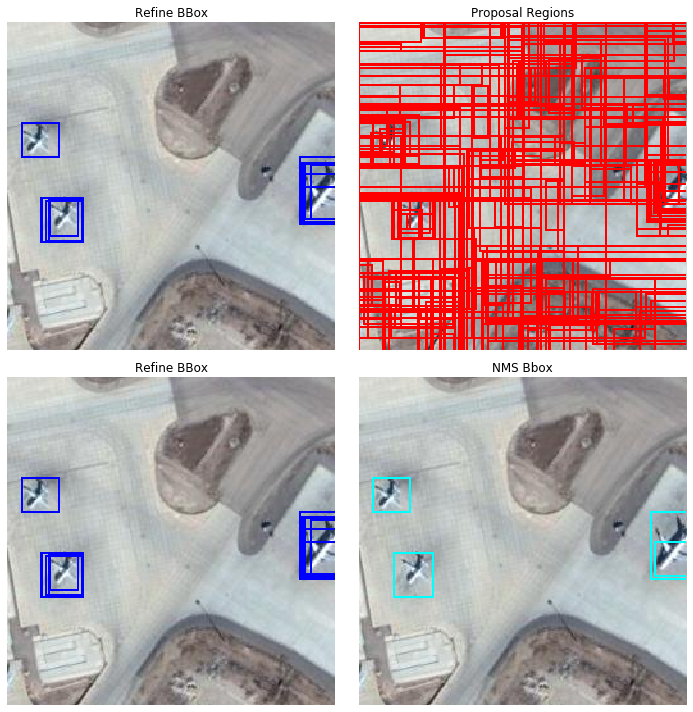

In [19]:
# Draw Boudning Box for Each Results...
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
DrawBoxes(img, refine_bbox, title='Refine BBox', color='blue', linestyle="-", ax=ax[0][0])
DrawBoxes(img, rois, title='Proposal Regions', color='red', linestyle="-", ax=ax[0][1])
DrawBoxes(img, refine_bbox, title='Refine BBox', color='blue', linestyle="-", ax=ax[1][0])
DrawBoxes(img, nms_bbox, title='NMS Bbox', color='cyan', linestyle="-", ax=ax[1][1])
plt.tight_layout() 

[3] [0.         0.         0.         0.56194125]
[] [0.         0.37571157 0.         0.        ]
[2] [0.44352617 0.         0.52307692 0.        ]


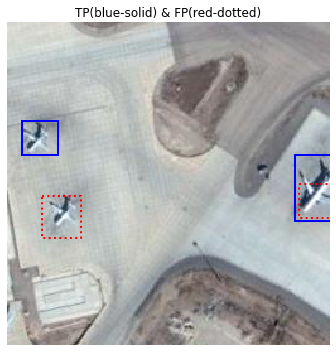

In [123]:
eval_results = np.array([], dtype=np.int32).reshape(0, 6)
gt_bbox = annotations[test_list[image_id]]
eval_results = np.vstack([eval_results, PerformanceMeasure(gt_bbox, nms_bbox)])
eval_results = np.insert(eval_results, eval_results.shape[1], image_id, axis=1)
# Display Measure(TP(blue-solid), FP(red-dotted ))
fig, ax = plt.subplots(1, figsize=(5, 5))
DrawBoxes(img, eval_results[np.where(eval_results[:,5] == 1)], title='TP(blue-solid) & FP(red-dotted)', color='blue', linestyle="-", ax=ax)
DrawBoxes(img, eval_results[np.where(eval_results[:,5] == 0)], title='TP(blue-solid) & FP(red-dotted)', color='red', linestyle=":", ax=ax)
plt.tight_layout() 

# eval_results

# Overall Test Image Inference And Evaluation

In [124]:
# Results Format
# [[xmin, ymin. xmax, ymax, confidence score, measure, image id]]
results = np.array([], dtype=np.int32).reshape(0, 7)

for i in tqdm(range(len(test_list))):
    results = np.vstack([results, Inference(i, test_list[i])])
    
# Test Results 저장
np.save('test_results.npy', results)

[0] [0.88186548 0.45120534 0.44412431 0.         0.19130032 0.48511166
 0.158867   0.095953  ]
[3] [0.         0.         0.02672692 0.69215876 0.         0.
 0.         0.        ]
[0] [0.71847507 0.         0.        ]
[] [0. 0. 0.]
[2] [0.         0.         0.60026798]
[1] [0.         0.67151163 0.        ]
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[] []
[0] [0.66474385 0.49774134 0.41818182 0.3015873 ]
[0] [0.77695167 0.38740483 0.35064935 0.        ]
[0] [0.80789946 0.         0.40849036 0.07334963 0.02671119]
[1 4] [0.         0.72651357 0.06043745 0.44425087 0.5605948 ]
[0] [0.7421875 0.       ]
[1] [0.         0.85742838]
[1] [0.         0.83333333 0.        ]
[0] [0.58513932 0.         0.49131514]
[] []
[] []
[] []
[3] [0.         0.         0.         0.56194125]
[] [0.         0.37571157 0.         0.        ]
[2] [0.44352617 0.         0.52307692 0.        ]
[0] [0.62271062 0.        ]
[1] [0.         0.76504534]
[0] [0.76153846 0.        ]
[1] [0.         0.83

[1 4] [0.         0.71095153 0.08924162 0.         0.58704261 0.
 0.         0.25559883 0.10389311 0.08705922]
[0 3] [0.80854889 0.         0.43965872 0.54692842 0.         0.35955056
 0.3692862  0.         0.34716482 0.        ]
[0 2 3] [0.55805065 0.         0.65126256 0.69142125 0.11097411 0.38988907
 0.39271746 0.         0.        ]
[1] [0.         0.78141084 0.         0.         0.         0.
 0.         0.3254743  0.31189598]
[4] [0.         0.         0.         0.03109815 0.62222222]
[0] [0.5443669  0.         0.42105263 0.         0.        ]
[1] [0.         0.75496689 0.         0.         0.        ]
[] [0.         0.         0.         0.4125     0.01427891]
[] [0. 0. 0. 0. 0.]
[2 6] [0.01678594 0.00277906 0.660746   0.         0.         0.34438306
 0.63267671]
[1 4] [0.41741253 0.78       0.01201068 0.38338279 0.56703297 0.
 0.        ]
[0 2] [0.58641975 0.         0.64047936 0.31972455]
[1] [0.         0.74463007 0.         0.        ]
[0 2] [0.5740872  0.         0.69

[ 3 12 13] [0.         0.         0.         0.61280321 0.         0.
 0.         0.         0.         0.         0.         0.13232218
 0.53881279 0.54736842 0.         0.14945201 0.19310345 0.        ]
[0] [0.8754913  0.         0.0027137  0.         0.         0.
 0.         0.41890865 0.         0.         0.         0.
 0.         0.         0.49176433 0.37171789 0.         0.16868217]
[1] [0.         0.84210526 0.         0.         0.         0.
 0.         0.         0.         0.         0.41986005 0.
 0.         0.         0.         0.         0.         0.        ]
[2] [0.01058405 0.         0.65737052 0.         0.03250662 0.45216316
 0.41199774 0.         0.         0.41821632 0.         0.00676329
 0.         0.         0.         0.06324769 0.         0.        ]
[4 8] [0.         0.         0.02957682 0.01796641 0.53828125 0.
 0.         0.         0.77238029 0.12956478 0.         0.42542468
 0.         0.         0.         0.04124473 0.         0.        ]
[0 1 2 3]

[1] [0.         0.86989699 0.         0.         0.49875    0.
 0.         0.         0.        ]
[0] [0.87481591 0.01086366 0.         0.         0.         0.34361043
 0.         0.45522388 0.        ]
[2 3] [0.         0.         0.66042781 0.62232143 0.         0.
 0.41785714 0.         0.38834951]
[0 1] [0.6043956  0.59440124]
[0 2 4] [0.62584023 0.49941171 0.6509296  0.17539923 0.59954515 0.39044694
 0.21586279 0.39033423 0.25869421 0.01922912 0.09055622 0.0788332
 0.37338593 0.0329764 ]
[1] [0.         0.91530692 0.         0.         0.         0.
 0.34997029 0.        ]
[0] [0.60331998 0.         0.         0.         0.         0.
 0.         0.        ]
[2] [0.00132509 0.         0.60357675 0.         0.         0.
 0.         0.        ]
[5] [0.         0.         0.         0.         0.         0.70288625
 0.         0.        ]
[3] [0.         0.         0.         0.55381944 0.         0.
 0.         0.        ]
[4] [0.         0.02146844 0.         0.         0.6575529

In [125]:
def DrawPRCurve(x, y, title='Standard', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)

    # Draw PR Curve
    ax.plot(x, y, linewidth='2.0', linestyle="-", color='r',drawstyle='steps-post')
    ax.grid(alpha=.4,linestyle='--')
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    

### Evaluation(Precision, Recall, AP, PR Curve)

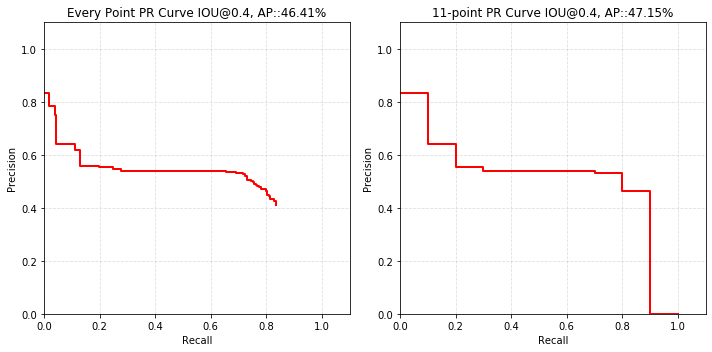

In [148]:
results = np.load('test_results.npy')

# Draw PR Curve
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Compute AP Using every point interpolation
AP , prec, rec= ComputeAP(results, mode=0)
DrawPRCurve(rec, prec, title='Every Point PR Curve IOU@0.4, AP::{:2.2f}%'.format(AP*100), ax=ax[0])

# Compute AP Using 11-point interpolation
AP , prec, rec= ComputeAP(results, mode=1)
DrawPRCurve(rec, prec, title='11-point PR Curve IOU@0.4, AP::{:2.2f}%'.format(AP*100), ax=ax[1])

plt.tight_layout()

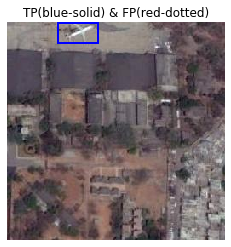

In [151]:
image_id=30

fig, ax = plt.subplots(1)
samples = results[np.where(results[:,6] == image_id)[0]]
img = cv2.imread(os.path.join(IMG_DIR, test_list[image_id]))

DrawBoxes(img, samples[np.where(samples[:,5] == 1)], title='TP(blue-solid) & FP(red-dotted)', color='blue', linestyle="-", ax=ax)
DrawBoxes(img, samples[np.where(samples[:,5] == 0)], title='TP(blue-solid) & FP(red-dotted)', color='red', linestyle=":", ax=ax)